# Deep Learning on the Highseas: Classifying Ships from Orbit

Dataset source: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery

In [ ]:
# Standard libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# OpenCV
import cv2

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from skimage.feature import hog
from sklearn import svm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

### Splitting Original Data Set into Training, Validation and Test Sets

In [ ]:
# Raw dataset
dataset_path = "/shipsnet-data/shipsnet"

# Create directories for training and test sets if they don't exist
train_path = "/shipsnet-data/train"
val_path = "/shipsnet-data/val"
test_path = "/shipsnet-data/test"

In [ ]:
if not os.path.exists(train_path):
    os.makedirs(train_path)

if not os.path.exists(val_path):
    os.makedirs(val_path)

if not os.path.exists(test_path):
    os.makedirs(test_path)

# Check if the dataset is already split
if (len(os.listdir(train_path)) > 0
    and len(os.listdir(val_path)) > 0
    and len(os.listdir(test_path)) > 0):
    print("Dataset is already split.")

else:
    print("Splitting dataset...")

    # Get the list of image files
    image_files = os.listdir(dataset_path)

    # Split the dataset into train (0.7), val (0.2) and test (0.1) sets
    train_files, temp_val_files = train_test_split(image_files, test_size=0.3, random_state=33)
    val_files, test_files = train_test_split(temp_val_files, test_size=0.33, random_state=33)


    # Copy the images to corresponding dir
    def copy_files(files, new_path):
      '''
      Copies files from data source to the data destination for data splitting

      Parameters:
          files (list): List of filenames to be copied.
          new_path (str): Path to the destination directory.
      '''
      for img in files:
          source_path = os.path.join(dataset_path, img)
          destination_path = os.path.join(new_path, img)
          shutil.copy(source_path, destination_path)

    copy_files(train_files, train_path)
    copy_files(val_files, val_path)
    copy_files(test_files, test_path)


    print("Dataset split complete.")


Dataset is already split.


## Loading Data Sets

In [ ]:
class ShipsNetDatasetPNG():
    """
    Custom dataset class for loading images.

    Parameters:
       images_dir (str): Path to the directory containing the images.
    """
    def __init__(self, images_dir):
        self.images_dir = images_dir
        self.transform = transforms.ToTensor()
        self.data = []
        self.labels = []

        for filename in os.listdir(images_dir):
            if filename.endswith(".png"):
                img_path = os.path.join(images_dir, filename)
                label = int(filename.split("_")[0])  # Extract label from filename
                img = self.load_image(img_path)
                self.data.append(img)
                self.labels.append(label)

    def load_image(self, path):
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {"data": self.data[idx] * 255, "label": self.labels[idx]}  # Data is scaled to 0 - 255
        return item

In [ ]:
# Loading the necessary datasets
train_set = ShipsNetDatasetPNG(train_path)
val_set = ShipsNetDatasetPNG(val_path)
test_set = ShipsNetDatasetPNG(test_path)

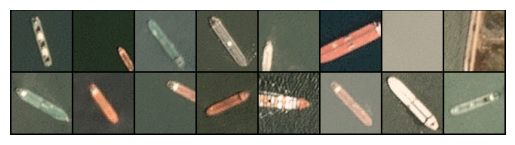

In [ ]:
def display_image(tensor):
  '''
  Display an image

  Parameters:
    torch tensor containing the images to display
  '''
  # Convert the PyTorch tensor to a NumPy array
  img_array = tensor.numpy()

  # Transpose the array to match the shape expected by matplotlib (H x W x C)
  img_array = np.transpose(img_array, (1, 2, 0))

  # Clip values to the valid range for RGB data
  img_array = np.clip(img_array, 0, 255)

  # Display the image
  plt.imshow(img_array.astype(np.uint8))
  plt.axis('off')
  plt.show()

# Display images
image_list = []
for i in range(0,16):
  image_list.append(train_set[i]['data'])


display_image(torchvision.utils.make_grid(image_list))

### Convolutional Network

Training Batch:    0 of 350, Running Loss: 0.6938
Training Batch:   10 of 350, Running Loss: 0.7387
Training Batch:   20 of 350, Running Loss: 0.7272
Training Batch:   30 of 350, Running Loss: 0.7199
Training Batch:   40 of 350, Running Loss: 0.7133
Training Batch:   50 of 350, Running Loss: 0.7062
Training Batch:   60 of 350, Running Loss: 0.7026
Training Batch:   70 of 350, Running Loss: 0.6941
Training Batch:   80 of 350, Running Loss: 0.6880
Training Batch:   90 of 350, Running Loss: 0.6827
Training Batch:  100 of 350, Running Loss: 0.6777
Training Batch:  110 of 350, Running Loss: 0.6692
Training Batch:  120 of 350, Running Loss: 0.6659
Training Batch:  130 of 350, Running Loss: 0.6639
Training Batch:  140 of 350, Running Loss: 0.6567
Training Batch:  150 of 350, Running Loss: 0.6510
Training Batch:  160 of 350, Running Loss: 0.6444
Training Batch:  170 of 350, Running Loss: 0.6394
Training Batch:  180 of 350, Running Loss: 0.6340
Training Batch:  190 of 350, Running Loss: 0.6272


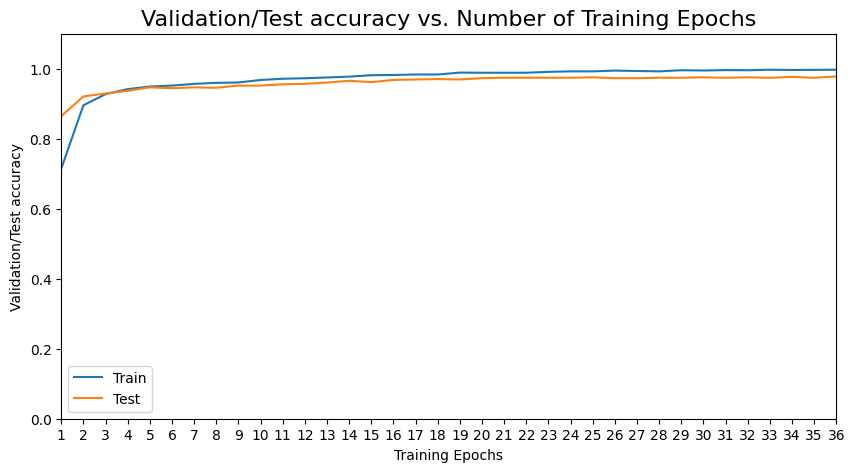

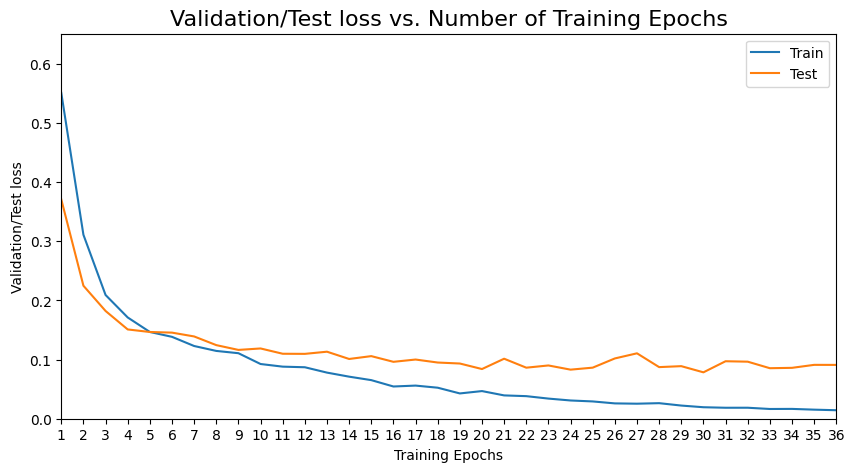

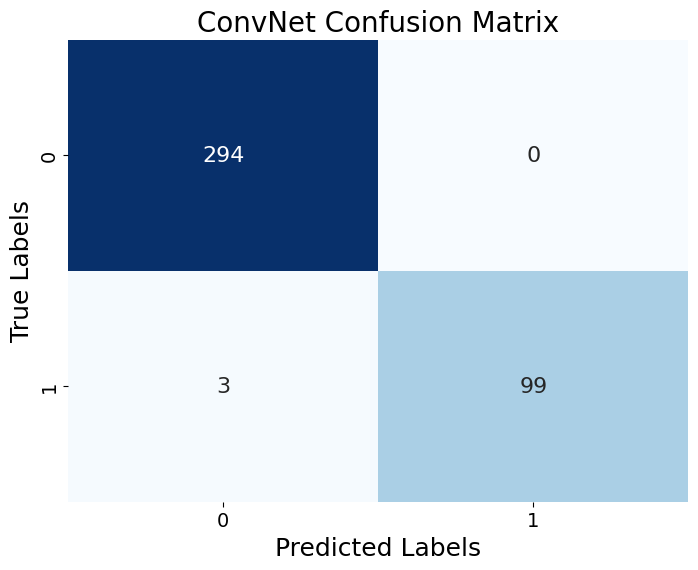

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(10368, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed for reproducability
torch.manual_seed(0)

# Hyper Parameters
batch_size = 8
num_epochs = 100
learning_rate = 0.0001
momentum = 0.9
early_stopping_patience = 10

loader_params = {
    'batch_size': batch_size,
    'num_workers': 0  # increase this value to use multiprocess data loading
}

global_y_pred = None


def plot(train_history, test_history, metric, best_epoch):
    """
    Plot training and validation metrics.

    Parameters:
        train_history (list): List of training metric values.
        test_history (list): List of validation metric values.
        metric (str): Metric name.
        best_epoch (int): Epoch where the best model was achieved.
    """


    plt.figure(figsize=(10, 5))
    plt.title(f"Validation/Test {metric} vs. Number of Training Epochs", fontsize=16)
    plt.xlabel(f"Training Epochs")
    plt.ylabel(f"Validation/Test {metric}")

    # Adjust the range of epochs to plot
    epochs = range(1, best_epoch + 1)
    train_hist_to_plot = train_history[:best_epoch]
    test_hist_to_plot = test_history[:best_epoch]

    plt.plot(epochs, train_hist_to_plot, label="Train")
    plt.plot(epochs, test_hist_to_plot, label="Test")
    plt.ylim((0, max(max(train_history), max(test_history)) + 0.1))
    plt.xlim((1, best_epoch))
    plt.xticks(np.arange(1, best_epoch + 1, 1.0))
    plt.legend()
    plt.savefig(f"{metric}.png")
    plt.show()


def training(model, train_loader, criterion, optimizer, device):
    """
    Train the model.

    Parameters:
        model (nn.Module): PyTorch model to train.
        train_loader (DataLoader): DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device (str): Device to perform training on.

    Returns:
        epoch_loss (float): Average loss over the epoch.
        epoch_acc (float): Accuracy over the epoch.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_batches = 0

    for batch_idx, batch in enumerate(train_loader):
        data, labels = batch["data"], batch["label"]
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the gradients, so previous gradients don't cause problems

        # Forward pass
        outputs = model(data)
        outputs = outputs.view(-1)  # Flatten to match with labels shape
        labels = labels.float()  # Convert labels to float
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calc statistics
        running_loss += loss.item() * data.size(0)
        preds = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        running_corrects += torch.sum(preds == labels)
        running_batches += 1

        if batch_idx % 10 == 0:
           print(f'Training Batch: {batch_idx:4} of {len(train_loader)}, Running Loss: {running_loss / (running_batches * data.size(0)):.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    print('-' * 10)
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc

def validation(model, val_loader, criterion, device):
    """
    Validate the model.

    Parameters:
        model (nn.Module): PyTorch model to validate.
        val_loader (DataLoader): DataLoader for validation data.
        criterion: Loss function.
        device (str): Device to perform validation on.

    Returns:
        epoch_loss (float): Average loss over the epoch.
        epoch_acc (float): Accuracy over the epoch.
    """

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_batches = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            data, labels = batch["data"], batch["label"]
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            outputs = outputs.view(-1)  # Flatten to match with labels shape

            labels = labels.float().view(-1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * data.size(0)
            preds = (outputs >= 0.5).float()
            running_corrects += torch.sum(preds == labels.data)
            running_batches += 1

            if batch_idx % 10 == 0:
               print(f'Validation Batch: {batch_idx:4} of {len(val_loader)}, Running Loss: {running_loss / (running_batches * data.size(0)):.4f}')

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    print('-' * 10)
    print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    """
    Evaluate the model on the test dataset.

    Parameters:
        model (nn.Module): PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        criterion: Loss function.
        device (str): Device to perform evaluation on.

    Returns:
        epoch_loss (float): Average loss over the test set.
        epoch_acc (float): Accuracy over the test set.
        roc_auc (float): Area under the ROC curve.
        confusion_matrix (ndarray): Confusion matrix.
        y_pred (list): Predicted labels.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_batches = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            data, labels = batch['data'], batch['label']
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            outputs = outputs.view(-1)

            labels = labels.float().view(-1)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * data.size(0)
            preds = (outputs >= 0.5).float()
            running_corrects += torch.sum(preds == labels)
            running_batches += 1

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Test Batch: {batch_idx:4} of {len(test_loader)}, Running Loss: {running_loss / (running_batches * data.size(0)):.4f}')

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    print('-' * 10)
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    roc_auc= roc_auc_score(y_true, y_pred)

    return epoch_loss, epoch_acc, roc_auc, cm, y_pred


def trainer(train_path, val_path, test_path):
    """
    Train, validate, and test the convolutional neural network model.

    Parameters:
        train_path (str): Path to the directory containing training images.
        val_path (str): Path to the directory containing validation images.
        test_path (str): Path to the directory containing test images.
    """

    model = ConvNet()
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for sigmoid activation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_set, shuffle=True, **loader_params) # Shuffle so model does not lean order of train exmapkes
    val_loader = DataLoader(val_set, shuffle=False, **loader_params)
    test_loader = DataLoader(test_set, shuffle=False, **loader_params)

    train_acc_history = []
    val_acc_history = []

    train_loss_history = []
    val_loss_history = []


    best_val_acc = 0  # Initialize the best validation accuracy
    patience_counter = 0


    for epoch in range(num_epochs):
        train_loss, train_acc = training(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validation(model, val_loader, criterion, device)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            best_epoch = epoch + 1

            patience_counter = 0 # Reset patience counter

        else:
            patience_counter += 1 # Add + 1 on patience counter if validation accuracy does not improve

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping after {early_stopping_patience} epochs without improvement.")
            break

    print(f"Best Model: Epoch {best_epoch}, Validation Accuracy: {best_val_acc:.4f}")

    test_loss, test_acc, test_auc, test_cm, test_y_pred = test(model, test_loader, criterion, device)

    global global_y_pred
    global_y_pred = test_y_pred

    print(f"Test Accuracy: {np.round(test_acc.cpu().numpy(),5)}")
    print(f"Test AUC score: {round(test_auc,3)}")

     # Plotting
    train_acc_history = [h.cpu().numpy() for h in train_acc_history]
    val_acc_history = [h.cpu().numpy() for h in val_acc_history]

    plot(train_acc_history, val_acc_history, 'accuracy', best_epoch)
    plot(train_loss_history, val_loss_history, 'loss', best_epochc)

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='.0f', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title('ConvNet Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Labels', fontsize=18)
    plt.ylabel('True Labels', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/shipsnet-data/shipsnet"
    train_path = "/content/drive/MyDrive/shipsnet-data/train"
    val_path = "/content/drive/MyDrive/shipsnet-data/val"
    test_path = "/content/drive/MyDrive/shipsnet-data/test"



    trainer(train_path, val_path, test_path)

SVM

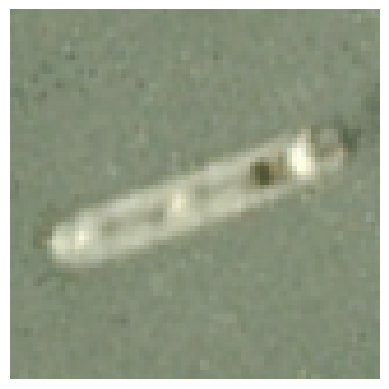

In [ ]:
display_image(train_set[15]['data'])

In [ ]:
train_data_gray = [cv2.cvtColor(np.array(img.permute(1, 2, 0)), cv2.COLOR_RGB2GRAY) for img in train_set.data]
val_data_gray = [cv2.cvtColor(np.array(img.permute(1, 2, 0)), cv2.COLOR_RGB2GRAY) for img in val_set.data]
test_data_gray = [cv2.cvtColor(np.array(img.permute(1, 2, 0)), cv2.COLOR_RGB2GRAY) for img in test_set.data]

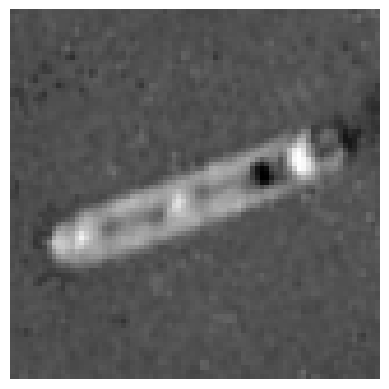

In [ ]:
plt.imshow(train_data_gray[15], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def compute_hog_features(images_gray, ppc=16):
    """
    Compute HOG features for a list of grayscale images.

    Args:
        images_gray (list): List of grayscale images.
        ppc (int): Pixels per cell parameter for HOG computation.

    Returns:
        list: List of HOG feature descriptors.
        list: List of HOG visualizations.
    """
    hog_features = []
    hog_images = []

    for image in images_gray:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(ppc, ppc), cells_per_block=(4, 4), block_norm='L2', visualize=True)
        hog_features.append(fd)
        hog_images.append(hog_image)

    return hog_features, hog_images


hog_features_train, hog_images_train = compute_hog_features(train_data_gray)
hog_features_val, hog_images_val = compute_hog_features(val_data_gray)
hog_features_test, hog_images_test = compute_hog_features(test_data_gray)

X_train = np.array(hog_features_train)
y_train = np.array(train_set.labels)
X_val = np.array(hog_features_val)
y_val = np.array(val_set.labels)
X_test = np.array(hog_features_test)
y_test = np.array(test_set.labels)

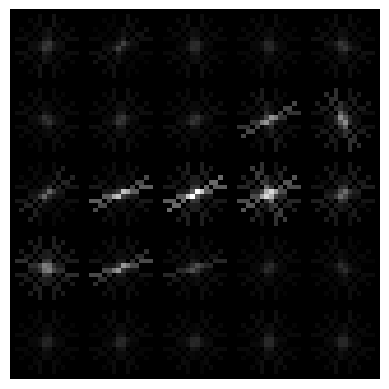

In [ ]:
plt.imshow(hog_images_train[15], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 3, 5, 7,  10, 25],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create the SVM classifier
svm_model = svm.SVC()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Train the model on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
val_accuracy = best_svm_model.score(X_val, y_val)
print("Validation Accuracy (best model):", val_accuracy)

# Evaluate the best model on the test set
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy (best model):", test_accuracy)

Best hyperparameters: {'C': 5, 'kernel': 'rbf'}
Validation Accuracy (best model): 0.9937810945273632
Test Accuracy (best model): 0.9924242424242424


In [ ]:
y_pred = best_svm_model.predict(X_test)

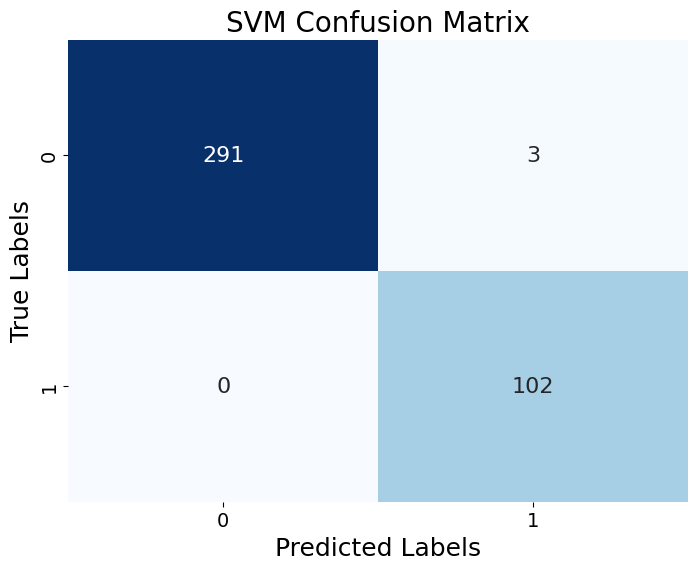

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('SVM Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Visualizing Wrong Classified Images

In [ ]:
def display_wrong_classified_images(image_tensors, actual_classes, predicted_classes):
    """
    Display multiple images side by side with their actual and predicted classes as titles.

    Parameters:
        image_tensors (list): List of tensors containing the images to display.
        actual_classes (list): List of actual classes for each image.
        predicted_classes (list): List of predicted classes for each image.
    """
    num_images = len(image_tensors)

    fig, axs = plt.subplots(1, num_images, figsize=(12, 4))  # Adjust the figure size as needed

    for i in range(num_images):
        # Convert the PyTorch tensor to a NumPy array and transpose it
        image_np = image_tensors[i].cpu().numpy().transpose((1, 2, 0))

        # Normalize pixel values to the range [0, 1]
        image_np = image_np / 255.0

        # Display the image
        axs[i].imshow(image_np)
        axs[i].axis('off')

        # Add annotations for actual and predicted classes as titles
        axs[i].set_title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}', fontsize=15, color='black')

    plt.tight_layout()
    plt.show()

#### For ConvNet

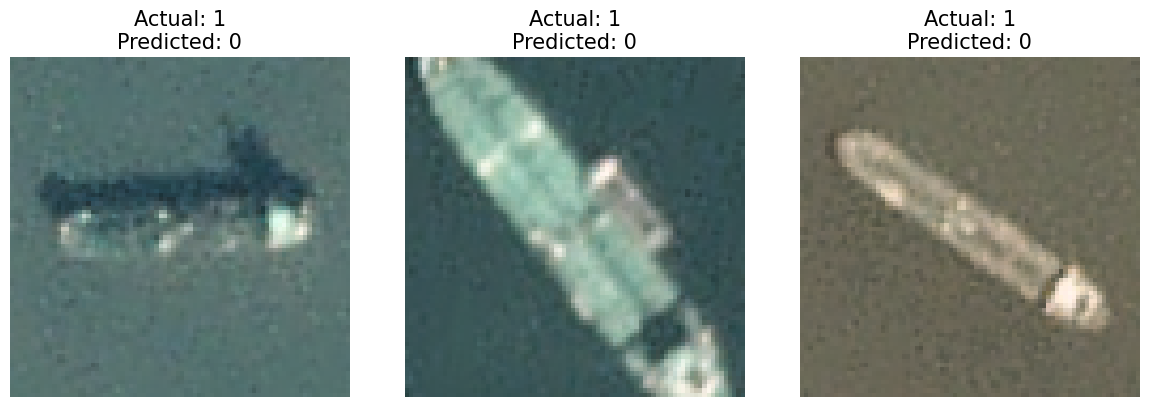

In [ ]:
test_labels = np.array([item['label'] for item in test_set])

# Find indices where true labels do not match predicted labels
mismatch_indices = np.where(test_labels != global_y_pred)[0]

global_y_pred = np.array(global_y_pred)

# Display incorrectly classified images
display_wrong_classified_images([test_set[i]['data'] for i in mismatch_indices], test_labels[mismatch_indices], global_y_pred[mismatch_indices].astype(int))


#### For SVM

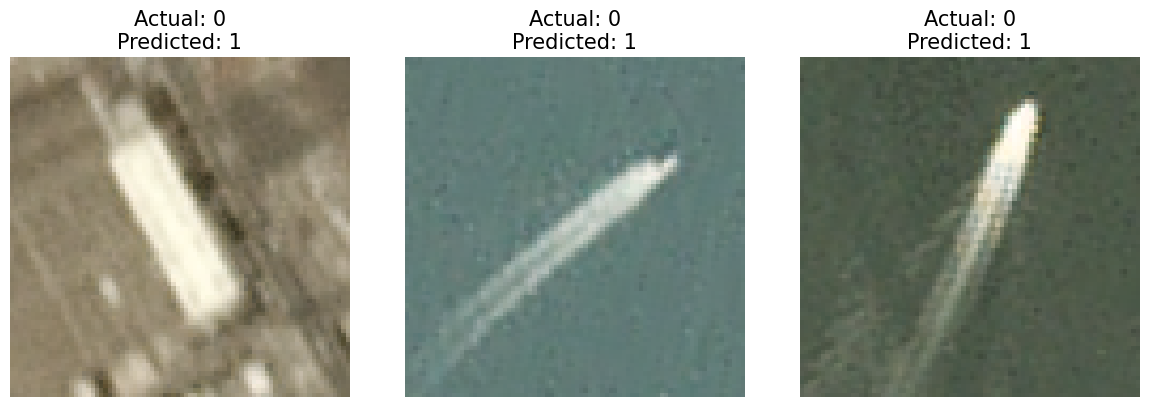

In [ ]:
mismatch_indices = np.where(y_test!= y_pred)[0]
# Display images
image_list = []
for i in mismatch_indices:
  image_list.append(test_set[i]['data'])


display_wrong_classified_images(image_list,y_test[mismatch_indices],y_pred[mismatch_indices])